# Experimenting with Classical Augmentations 
This notebook documents the process of selecting the most appropriate classical transformation for the lipohypertrophy capstone project. A set of promising transfromations were selected for further examination by experimenting with the [albumentation demo tool](https://albumentations-demo.herokuapp.com).  

> This notebook was run on Kaggle with the GPU Accelator Enabled. The data used for this notebook is available on the MDS-Capstone-GDLR OneDrive. You can find the data used in this notebook by navigating to the `Data Processed Ultrasound` directory and downloading the `data_split_mapped` sub-directory.   

In [1]:
# Import Libraries
import torch
import os
from PIL import Image
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, utils, models
from torch import nn, optim
from collections import OrderedDict
from albumentations.pytorch import ToTensorV2

In [2]:
# Define a custom dataset class (required for albumentations)
class LipoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        
        # Create a list of filepaths of images and the respective label
        self.samples = []

        for i in os.listdir(root_dir):
            if i in ["positive", 'negative']:
                folder = os.path.join(root_dir, i)
                target = folder.split("/")[-1]
                for label in os.listdir(folder):
                    filepath = os.path.join(folder, label)
                    self.samples.append((target, filepath))


    def __len__(self):
        # Get the length of the samples 
        return len(self.samples)

    def __getitem__(self, index):
        # Implement logic to get an image and its label using the received index.
        #
        # `image` should be a NumPy array with the shape [height, width, num_channels].
        # If an image contains three color channels, it should use an RGB color scheme.
        #
        # `label` should be an integer in the range [0, model.num_classes - 1] where `model.num_classes`
        # is a value set in the `search.yaml` file.
        
        # get the filepath of the image based on the index and convert it to 
        # color scale and then into a numpy array
        image = np.array(Image.open(self.samples[index][1]).convert("RGB"))

        # maps a label to an integer value
        label_to_int = {"positive": 1, "negative": 0}
        label = label_to_int[self.samples[index][0]]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [3]:
# Test if the above class works and outputs the appropriate info
if __name__ == '__main__':
    dataset = LipoDataset('/kaggle/input/capstonelipo/data_split_mapped/train') 
    print(len(dataset))
    print(dataset[0][0].shape)

183
(385, 429, 3)


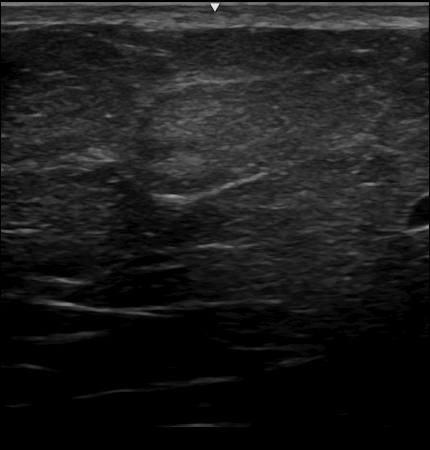

In [4]:
# Example of an image
Image.open('/kaggle/input/capstonelipo/data_split_mapped/train/positive/USLH053_04.png').convert('L')

In [5]:
# Convert image RGB scale and then into a numpy array
img = np.array(Image.open('/kaggle/input/capstonelipo/data_split_mapped/train/positive/USLH053_04.png').convert('RGB'))

In [6]:
# Define Transformations for Validation Set
transform_valid = A.Compose(
    [
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

# Define set of manual transformations to be tested

transform_flip =  A.Compose(
    [
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

transform_flip_equalize =  A.Compose(
    [
        A.Equalize(),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

transform_flip_equalize_blur =  A.Compose(
    [
        A.Blur(blur_limit=(3, 6)),
        A.Equalize(),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

transform_flip_equalize_contrast =  A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0, 1.0)),
        A.Equalize(),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

transform_flip_contrast =  A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0, 1.0)),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

transform_flip_clahe =  A.Compose(
    [
        A.CLAHE(),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

transform_all = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0, 1.0)),
        A.CLAHE(),
        A.Downscale(), 
        A.ISONoise(),
        A.RandomSnow(),
        A.Equalize(),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

In [7]:
# Define list of different transformations
transform_list = [transform_flip,
                  transform_flip_equalize,
                  transform_flip_equalize_blur,
                  transform_flip_equalize_contrast,
                  transform_flip_contrast,
                  transform_flip_clahe,
                  transform_all]

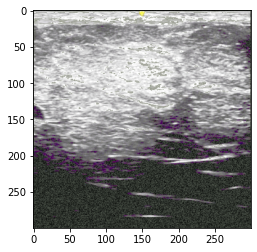

In [8]:
# Create a transformed image to view 
transformed = transform_all(image=img)
transformed_image = transformed["image"]

# View the image 
%matplotlib inline


reverse_preprocess = transforms.Compose([
    transforms.ToPILImage(),
    np.array,
])

plt.imshow(reverse_preprocess(transformed_image));

In [9]:
# Create datasets for different transformations and tranform the images 
datasets = []
for index, transform in enumerate(transform_list):
    dataset = LipoDataset('/kaggle/input/capstonelipo/data_split_mapped/train', transform=transform)
    datasets.append(dataset)
v_dataset = LipoDataset('/kaggle/input/capstonelipo/data_split_mapped/val', transform=transform_valid)

In [11]:
# Create dataloaders for different transformations
train_loaders = []
for dataset in datasets:
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
    train_loaders.append(train_loader)
valid_loader = torch.utils.data.DataLoader(v_dataset, batch_size=8, shuffle=True)

In [12]:
# Set up pre-trained model
densenet = models.densenet121(pretrained=True)

new_layers = nn.Sequential(OrderedDict([
    ('new1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('new2', nn.Linear(500, 1))
]))
densenet.classifier = new_layers

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
densenet.to(device);


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [13]:
# Simple trainer function with early stopping
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    data_type = torch.float32
    valid_loss = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device,data_type), y.to(device,data_type)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.type(data_type))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(data_type).sum().item()
        train_accuracy = train_batch_acc / len(train_loader.dataset)
        
        # Validation
        confusion_matrix = torch.zeros(2, 2)
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device,data_type), y.to(device,data_type)
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(data_type))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(data_type).sum().item()
        valid_accuracy = valid_batch_acc / len(valid_loader.dataset)
        valid_loss.append(valid_batch_loss / len(valid_loader))        
        
        with torch.no_grad():
            for i, (inputs, classes) in enumerate(valid_loader):
                inputs = inputs.to(device, data_type)
                classes = classes.to(device, data_type)
                outputs = model(inputs).flatten()
                preds = torch.sigmoid(outputs) > 0.5
                for t, p in zip(classes.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1
        recall = confusion_matrix.numpy()[1,1]/(confusion_matrix.numpy()[1,1]+confusion_matrix.numpy()[1,0])
        model.train()
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy:.2f}.",
                  f"Valid Accuracy: {valid_accuracy:.2f}.",
                  f"Valid Recall: {recall:.2f}")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy, "Valid_recall":recall}

### The results of the experiments can be found below:

The pre-trained `densenet` model was trained for 40 epochs (with early stopping) and validation accuracy and recall scores were examined to select the most appropriate augmentations. The performance wil vary on different runs. Overall, the vertical and horizontal flipping and brightness and contrast adjustment were providing stable increased performance.    

In [16]:
# Flip only
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
result0 = trainer(densenet, criterion, optimizer, train_loaders[0], valid_loader, device, epochs=40)

Epoch 1: Train Accuracy: 0.69. Valid Accuracy: 0.69. Valid Recall: 1.00
Epoch 2: Train Accuracy: 0.79. Valid Accuracy: 0.67. Valid Recall: 0.50
Epoch 3: Train Accuracy: 0.79. Valid Accuracy: 0.82. Valid Recall: 1.00
Epoch 4: Train Accuracy: 0.83. Valid Accuracy: 0.67. Valid Recall: 0.45
Epoch 5: Train Accuracy: 0.81. Valid Accuracy: 0.79. Valid Recall: 0.85
Epoch 6: Train Accuracy: 0.84. Valid Accuracy: 0.67. Valid Recall: 0.90
Epoch 7: Train Accuracy: 0.80. Valid Accuracy: 0.79. Valid Recall: 0.95
Epoch 8: Train Accuracy: 0.83. Valid Accuracy: 0.79. Valid Recall: 0.95
Epoch 9: Train Accuracy: 0.84. Valid Accuracy: 0.72. Valid Recall: 0.65
Epoch 10: Train Accuracy: 0.83. Valid Accuracy: 0.69. Valid Recall: 1.00
Epoch 11: Train Accuracy: 0.82. Valid Accuracy: 0.82. Valid Recall: 0.90
Epoch 12: Train Accuracy: 0.80. Valid Accuracy: 0.77. Valid Recall: 0.90
Epoch 13: Train Accuracy: 0.86. Valid Accuracy: 0.87. Valid Recall: 0.95
Epoch 14: Train Accuracy: 0.84. Valid Accuracy: 0.74. Valid 

> Restart kernel, run up to cell 13 and only the cell below. This ensures that you are training a newly instantiated model.

In [14]:
# Flip, Equalize
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
result1 = trainer(densenet, criterion, optimizer, train_loaders[1], valid_loader, device, epochs=40)

Epoch 1: Train Accuracy: 0.61. Valid Accuracy: 0.64. Valid Recall: 0.75
Epoch 2: Train Accuracy: 0.70. Valid Accuracy: 0.74. Valid Recall: 0.95
Epoch 3: Train Accuracy: 0.69. Valid Accuracy: 0.59. Valid Recall: 0.20
Epoch 4: Train Accuracy: 0.79. Valid Accuracy: 0.77. Valid Recall: 0.95
Epoch 5: Train Accuracy: 0.77. Valid Accuracy: 0.74. Valid Recall: 0.90
Epoch 6: Train Accuracy: 0.70. Valid Accuracy: 0.74. Valid Recall: 0.95
Epoch 7: Train Accuracy: 0.78. Valid Accuracy: 0.62. Valid Recall: 1.00
Epoch 8: Train Accuracy: 0.73. Valid Accuracy: 0.79. Valid Recall: 0.90
Epoch 9: Train Accuracy: 0.78. Valid Accuracy: 0.79. Valid Recall: 0.70
Epoch 10: Train Accuracy: 0.78. Valid Accuracy: 0.77. Valid Recall: 1.00
Epoch 11: Train Accuracy: 0.81. Valid Accuracy: 0.72. Valid Recall: 1.00
Epoch 12: Train Accuracy: 0.79. Valid Accuracy: 0.77. Valid Recall: 0.60
Epoch 13: Train Accuracy: 0.75. Valid Accuracy: 0.69. Valid Recall: 0.85
Epoch 14: Train Accuracy: 0.79. Valid Accuracy: 0.72. Valid 

> Restart kernel, run up to cell 13 and only the cell below. This ensures that you are training a newly instantiated model.

In [14]:
# Flip, Equalize, Blur
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
result2 = trainer(densenet, criterion, optimizer, train_loaders[2], valid_loader, device, epochs=40)

Epoch 1: Train Accuracy: 0.58. Valid Accuracy: 0.64. Valid Recall: 0.40
Epoch 2: Train Accuracy: 0.63. Valid Accuracy: 0.54. Valid Recall: 1.00
Epoch 3: Train Accuracy: 0.68. Valid Accuracy: 0.38. Valid Recall: 0.60
Epoch 4: Train Accuracy: 0.66. Valid Accuracy: 0.59. Valid Recall: 1.00
Epoch 5: Train Accuracy: 0.71. Valid Accuracy: 0.69. Valid Recall: 0.80
Epoch 6: Train Accuracy: 0.66. Valid Accuracy: 0.77. Valid Recall: 0.85
Epoch 7: Train Accuracy: 0.71. Valid Accuracy: 0.62. Valid Recall: 0.75
Epoch 8: Train Accuracy: 0.68. Valid Accuracy: 0.67. Valid Recall: 0.85
Epoch 9: Train Accuracy: 0.74. Valid Accuracy: 0.67. Valid Recall: 0.75
Epoch 10: Train Accuracy: 0.75. Valid Accuracy: 0.64. Valid Recall: 0.45
Epoch 11: Train Accuracy: 0.74. Valid Accuracy: 0.54. Valid Recall: 0.75
Epoch 12: Train Accuracy: 0.69. Valid Accuracy: 0.72. Valid Recall: 0.75
Epoch 13: Train Accuracy: 0.74. Valid Accuracy: 0.74. Valid Recall: 0.85
Epoch 14: Train Accuracy: 0.69. Valid Accuracy: 0.59. Valid 

> Restart kernel, run up to cell 13 and only the cell below. This ensures that you are training a newly instantiated model.

In [14]:
# Flip, Equalize, Contrast
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
result3 = trainer(densenet, criterion, optimizer, train_loaders[3], valid_loader, device, epochs=40)

Epoch 1: Train Accuracy: 0.57. Valid Accuracy: 0.49. Valid Recall: 0.00
Epoch 2: Train Accuracy: 0.62. Valid Accuracy: 0.72. Valid Recall: 1.00
Epoch 3: Train Accuracy: 0.70. Valid Accuracy: 0.49. Valid Recall: 0.00
Epoch 4: Train Accuracy: 0.67. Valid Accuracy: 0.51. Valid Recall: 1.00
Epoch 5: Train Accuracy: 0.66. Valid Accuracy: 0.51. Valid Recall: 1.00
Epoch 6: Train Accuracy: 0.75. Valid Accuracy: 0.69. Valid Recall: 0.55
Epoch 7: Train Accuracy: 0.69. Valid Accuracy: 0.69. Valid Recall: 0.70
Epoch 8: Train Accuracy: 0.69. Valid Accuracy: 0.69. Valid Recall: 0.85
Epoch 9: Train Accuracy: 0.73. Valid Accuracy: 0.69. Valid Recall: 0.45
Epoch 10: Train Accuracy: 0.74. Valid Accuracy: 0.49. Valid Recall: 0.55
Epoch 11: Train Accuracy: 0.73. Valid Accuracy: 0.79. Valid Recall: 1.00
Epoch 12: Train Accuracy: 0.82. Valid Accuracy: 0.77. Valid Recall: 0.90
Epoch 13: Train Accuracy: 0.74. Valid Accuracy: 0.67. Valid Recall: 0.40
Epoch 14: Train Accuracy: 0.77. Valid Accuracy: 0.85. Valid 

> Restart kernel, run up to cell 13 and only the cell below. This ensures that you are training a newly instantiated model.

In [16]:
# Flip, Contrast
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
result4 = trainer(densenet, criterion, optimizer, train_loaders[4], valid_loader, device, epochs=50)

Epoch 1: Train Accuracy: 0.65. Valid Accuracy: 0.62. Valid Recall: 0.30
Epoch 2: Train Accuracy: 0.66. Valid Accuracy: 0.51. Valid Recall: 1.00
Epoch 3: Train Accuracy: 0.69. Valid Accuracy: 0.49. Valid Recall: 0.85
Epoch 4: Train Accuracy: 0.69. Valid Accuracy: 0.59. Valid Recall: 0.30
Epoch 5: Train Accuracy: 0.75. Valid Accuracy: 0.67. Valid Recall: 0.60
Epoch 6: Train Accuracy: 0.72. Valid Accuracy: 0.59. Valid Recall: 0.80
Epoch 7: Train Accuracy: 0.84. Valid Accuracy: 0.49. Valid Recall: 0.00
Epoch 8: Train Accuracy: 0.74. Valid Accuracy: 0.72. Valid Recall: 0.65
Epoch 9: Train Accuracy: 0.81. Valid Accuracy: 0.82. Valid Recall: 0.90
Epoch 10: Train Accuracy: 0.76. Valid Accuracy: 0.77. Valid Recall: 0.80
Epoch 11: Train Accuracy: 0.76. Valid Accuracy: 0.85. Valid Recall: 0.90
Epoch 12: Train Accuracy: 0.82. Valid Accuracy: 0.69. Valid Recall: 0.90
Epoch 13: Train Accuracy: 0.79. Valid Accuracy: 0.79. Valid Recall: 0.90
Epoch 14: Train Accuracy: 0.85. Valid Accuracy: 0.85. Valid 

> Restart kernel, run up to cell 13 and only the cell below. This ensures that you are training a newly instantiated model.

In [16]:
# Flip, CLAHE 
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
result5 = trainer(densenet, criterion, optimizer, train_loaders[5], valid_loader, device, epochs=40)

Epoch 1: Train Accuracy: 0.61. Valid Accuracy: 0.54. Valid Recall: 0.15
Epoch 2: Train Accuracy: 0.69. Valid Accuracy: 0.67. Valid Recall: 1.00
Epoch 3: Train Accuracy: 0.77. Valid Accuracy: 0.77. Valid Recall: 0.80
Epoch 4: Train Accuracy: 0.75. Valid Accuracy: 0.69. Valid Recall: 0.50
Epoch 5: Train Accuracy: 0.74. Valid Accuracy: 0.59. Valid Recall: 0.30
Epoch 6: Train Accuracy: 0.77. Valid Accuracy: 0.62. Valid Recall: 0.35
Epoch 7: Train Accuracy: 0.81. Valid Accuracy: 0.67. Valid Recall: 0.45
Epoch 8: Train Accuracy: 0.77. Valid Accuracy: 0.67. Valid Recall: 0.50
Epoch 9: Train Accuracy: 0.73. Valid Accuracy: 0.67. Valid Recall: 0.45
Epoch 10: Train Accuracy: 0.80. Valid Accuracy: 0.72. Valid Recall: 0.75
Epoch 11: Train Accuracy: 0.74. Valid Accuracy: 0.69. Valid Recall: 0.85
Epoch 12: Train Accuracy: 0.78. Valid Accuracy: 0.77. Valid Recall: 0.95
Epoch 13: Train Accuracy: 0.81. Valid Accuracy: 0.51. Valid Recall: 0.05
Epoch 14: Train Accuracy: 0.75. Valid Accuracy: 0.72. Valid 

> Restart kernel, run up to cell 13 and only the cell below. This ensures that you are training a newly instantiated model.

In [14]:
# All transforms
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
result6 = trainer(densenet, criterion, optimizer, train_loaders[6], valid_loader, device, epochs=40)

Epoch 1: Train Accuracy: 0.50. Valid Accuracy: 0.64. Valid Recall: 0.35
Epoch 2: Train Accuracy: 0.64. Valid Accuracy: 0.54. Valid Recall: 0.10
Epoch 3: Train Accuracy: 0.63. Valid Accuracy: 0.51. Valid Recall: 1.00
Epoch 4: Train Accuracy: 0.64. Valid Accuracy: 0.51. Valid Recall: 0.10
Epoch 5: Train Accuracy: 0.65. Valid Accuracy: 0.44. Valid Recall: 0.65
Epoch 6: Train Accuracy: 0.63. Valid Accuracy: 0.54. Valid Recall: 0.10
Epoch 7: Train Accuracy: 0.63. Valid Accuracy: 0.56. Valid Recall: 0.45
Epoch 8: Train Accuracy: 0.62. Valid Accuracy: 0.62. Valid Recall: 0.25
Epoch 9: Train Accuracy: 0.70. Valid Accuracy: 0.59. Valid Recall: 0.20
Epoch 10: Train Accuracy: 0.71. Valid Accuracy: 0.54. Valid Recall: 0.10
Epoch 11: Train Accuracy: 0.67. Valid Accuracy: 0.72. Valid Recall: 0.50
Epoch 12: Train Accuracy: 0.64. Valid Accuracy: 0.64. Valid Recall: 0.30
Epoch 13: Train Accuracy: 0.70. Valid Accuracy: 0.69. Valid Recall: 0.45
Epoch 14: Train Accuracy: 0.65. Valid Accuracy: 0.72. Valid 

<br>